# Test biaslyze with the toxic comments dataset

Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [114]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

## Load and prepare data

In [115]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [116]:
# make the classification problem binary
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [117]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [118]:
clf.fit(df.comment_text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [119]:
train_pred = clf.predict(df.comment_text)
print(accuracy_score(df.target, train_pred))

0.9753589311341033


### probe the model a bit

In [120]:
test_text = "Jews and muslims are great friends!"

print(clf.predict_proba([test_text]))

[[0.95867571 0.04132429]]


In [121]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.95762929 0.04237071]]


In [122]:
test_text = "That man is great!"

print(clf.predict_proba([test_text]))

[[0.96072211 0.03927789]]


In [123]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.66363873 0.33636127]]


## Test LIME based bias detection with keywords

In [124]:
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [125]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=1000),
    n_top_keywords=30,
    use_tokenizer=True
)

In [126]:
test_texts = df.comment_text.sample(1000)
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-05-04 15:18:04.909 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.35it/s]
2023-05-04 15:18:25.594 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 240 texts with protected concepts.
2023-05-04 15:18:25.595 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 240 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [02:47<00:00,  1.43it/s]


In [127]:
detection_res.summary()

Detected 175 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 144), ('nationality', 43), ('religion', 10), ('gendered words', 3)]
    Based on keywords: [('he', 37), ('his', 35), ('him', 14), ('they', 13), ('her', 11), ('she', 11), ('them', 7), ('man', 5), ('men', 5), ('guy', 5), ('son', 5), ('father', 5), ('jews', 5), ('their', 4), ('russian', 3), ('christian', 3), ('japan', 3), ('himself', 3), ('guys', 3), ('mother', 3)].


In [128]:
detection_res.details(group_by_concept=True)

Concept: gender
[{'reason': ['boy'], 'text': 'Yes, mon, unu mus like some kin of chiney-boy!'},
 {'reason': ['his'],
  'text': '"\n'
          '\n'
          ' Alexander or Justin? \n'
          '\n'
          'David Alexander Vincent? Or David Justin Vincent? Also, I think his '
          'real surname is ""Stupping"""'},
 {'reason': ['him'],
  'text': "It won't work because of the person we're dealing with. His ego is "
          'so big he refuses to acknowledge any wrongdoing or incorrect '
          'actions he has done. He selectively replies to the talk pages (if '
          'he replies at all), always avoiding the issues that would force him '
          "to admit what he's doing might not be the best way. Who in their "
          'right mind scours the net for one source to use instead of relying '
          'on consensus reports? To him, ONE article that says a band is emo '
          'is better than finding 10,000 that never make any mention of it '
          "regarding that 

In [129]:
test_df = df.iloc[test_texts.index]

In [130]:
test_df[test_df.target].reset_index().comment_text[4]

'2007 (UTC)\n\nYour continued rudeness and failure to remotely discuss your controversial administrative actions just confirms for me that you are a terrible administrator.  Whatever I can do to get your administrative tools taken away from you, I will do.   20:25, 1 March'

In [131]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [132]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [48]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', max_cluster_size=25)
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)

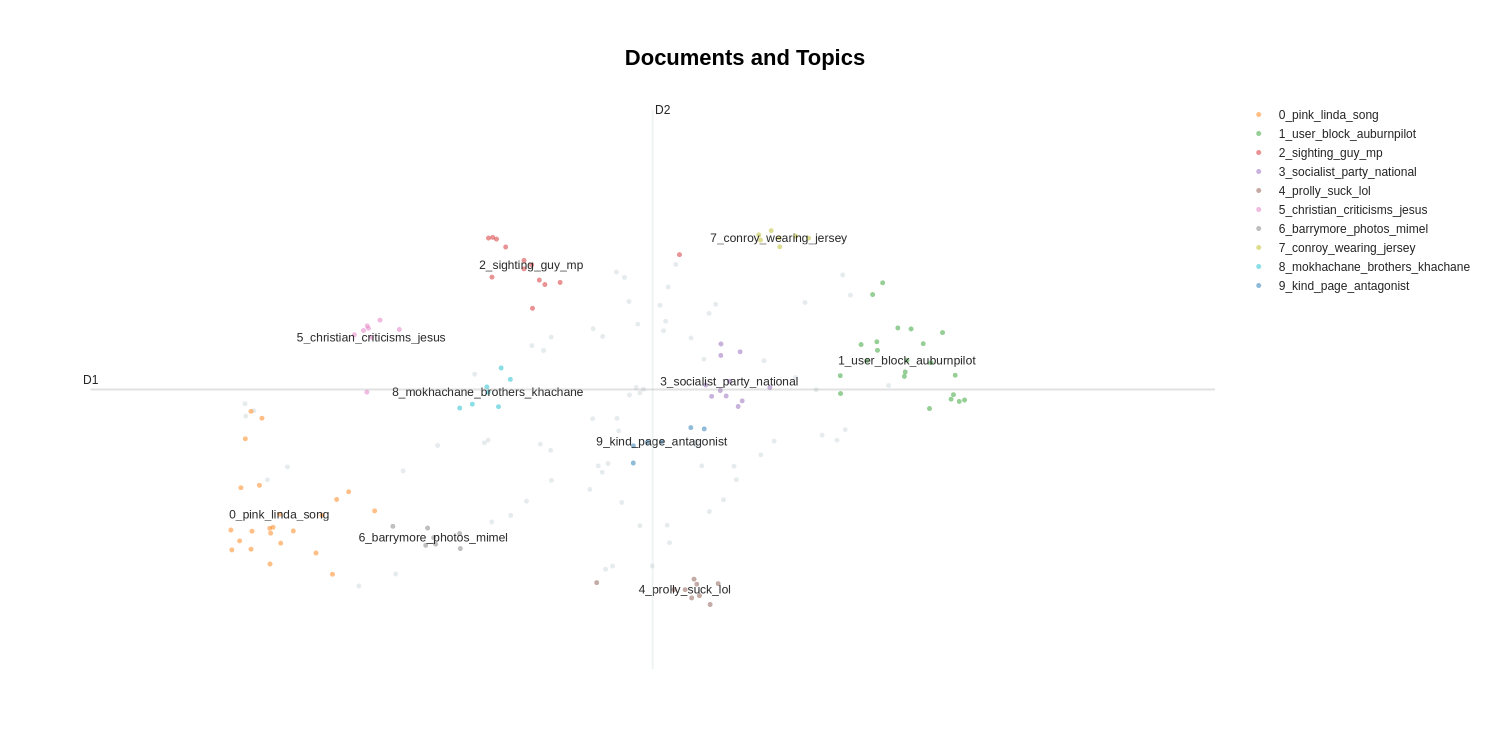

In [51]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [52]:
topic_model.topic_labels_

{-1: '-1_music_know_people_sla',
 0: '0_pink_linda_song_article',
 1: '1_user_block_auburnpilot_physicq210',
 2: '2_sighting_guy_mp_discovery',
 3: '3_socialist_party_national_nazi',
 4: '4_prolly_suck_lol_cus',
 5: '5_christian_criticisms_jesus_mormonism',
 6: '6_barrymore_photos_mimel_mainstream',
 7: '7_conroy_wearing_jersey_trade',
 8: '8_mokhachane_brothers_khachane_english',
 9: '9_kind_page_antagonist_just'}

In [54]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [50*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_10[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

## Testing a sentiment analysis model from huggingface

In [18]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [19]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [20]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [21]:
test_texts = df.comment_text.sample(50)
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

2023-04-13 12:04:44.419 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 50 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.77it/s]
2023-04-13 12:04:45.620 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 10 texts with protected concepts.
2023-04-13 12:04:45.621 | INFO     | biaslyze.evaluators:evaluate:42 - Started bias detection on 10 samples...
  0%|                                                                                                                                                                                              | 0/10 [01:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

## !! Very Experimental !!: Test masked language model based bias detection with keywords

In [10]:
from biaslyze.bias_detectors import MaskedKeywordBiasDetector
from biaslyze.concept_detectors import KeywordConceptDetector

In [11]:
bias_detector = MaskedKeywordBiasDetector(n_resample_keywords=20, use_tokenizer=True)

In [16]:
detection_res = bias_detector.detect(
    texts=df.comment_text.sample(1000),
    predict_func=clf.predict_proba
)

2023-04-14 11:53:45.266 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.95it/s]
2023-04-14 11:54:04.519 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 213 texts with protected concepts.
2023-04-14 11:54:04.520 | INFO     | biaslyze.evaluators:evaluate:109 - Started bias detection on 213 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:27<00:00,  7.67it/s]


In [17]:
detection_res.summary()

Detected 30 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 27), ('religion', 3)]
    Based on keywords: [('man', 14), ('he', 13), ('his', 9), ('she', 5), ('her', 4), ('jews', 3), ('brother', 1), ('female', 1), ('guy', 1), ('grandma', 1), ('men', 1), ('jew', 1)].


In [18]:
detection_res.details()

''" Here he posted ""in my name"""'' might contain bias ['gender']; reasons: ['he']
''"

 has offended me repeatedly'''
I attempted to reach a consensus with , but he ridiculed me: 
""and much less ""CNN talks about it"". Oooooh, I'm impressed! ) What kind of an argument is that, ""CNN talks about it""? hahahahahah""

Someone who makes this kind of comment doesn't want consensus, he wants to shove his view down everyone's thoats.

 has also offended and ridiculed me other times:
""Are you mentally challenged?""
""Now go watch the fireworks in Copacabana and stop crying, Mr Carioca. )""
""Man, you really are a nut job! ""
""Get a life, carioca""
""EconomistBR is the one who is being intolerant""

All I want is to talk with him about this and him to appologize for those uncalled for offenses"'' might contain bias ['gender']; reasons: ['man', 'he', 'his', 'man']
''I will definitely dignify you with an answer. It seems you are strongly making one thing for sure that a rumour when reported 

In [20]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

## Experiment with global importance of concept-keywords

In [11]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
key_detect = KeywordConceptDetector()

In [13]:
detected_texts = key_detect.detect(texts=df.comment_text)

2023-05-04 11:05:34.989 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 159571 texts...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159571/159571 [00:03<00:00, 40103.10it/s]
2023-05-04 11:05:38.974 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 137246 texts with protected concepts.


In [14]:
len(detected_texts)

137246

In [15]:
detected_texts[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [153]:
from typing import List

class Sample:
    
    def __init__(self, text: str, keyword: str, concept: str, tokenized: List[str]):
        self.text = text
        self.keyword = keyword
        self.concept = concept
        self.tokenized = tokenized
    
    def __repr__(self):
        return f"concept={self.concept}; keyword={self.keyword}; text={self.text}"

In [177]:
def extract_concept_samples(concept: str, texts: List[str], bias_eval: MaskedBiasEvaluator, N: int = 100):
    samples = []

    text_representations = bias_eval._tokenizer.pipe(texts[:N])
    for text, text_representation in tqdm(zip(texts[:N], text_representations)):
        present_keywords = list(
            keyword
            for keyword in CONCEPTS[concept]
            if keyword in (token.text.lower() for token in text_representation)
        )
        if present_keywords:
            for keyword in present_keywords:
                samples.append(
                    Sample(
                        text=text,
                        keyword=keyword,
                        concept=concept,
                        tokenized=text_representation,
                    )
                )
    print(f"Extracted {len(samples)} sample texts for concept {concept}")
    return samples

In [178]:
def calculate_counterfactual_score(bias_keyword: str, clf, samples):
    # change the text for all of them and predict
    original_scores = clf.predict_proba([sample.text for sample in samples])[:,1]
    replaced_texts = []
    #text_representations = bias_eval._tokenizer.pipe([sample.text for sample in samples])
    for sample in samples:
        resampled_text = "".join(
            [
                bias_keyword + token.whitespace_
                if token.text.lower() == sample.keyword.lower()
                else token.text + token.whitespace_
                for token in sample.tokenized
            ]
        )
        replaced_texts.append(resampled_text)

    predicted_scores = clf.predict_proba(replaced_texts)[:,1]
    
    #print(f"SenseScore: {np.mean(np.array(original_scores) - np.array(predicted_scores)):.5}")
    return original_scores, predicted_scores

In [184]:
def calculate_all_scores(texts: List[str], concept: str, clf, n_samples=1000):
    bias_eval = MaskedBiasEvaluator()
    score_dict = dict()
    
    if not n_samples:
        n_samples = len(texts)
    
    samples = extract_concept_samples(texts=texts, concept="gender", N=n_samples, bias_eval=bias_eval)
    
    for keyword in tqdm(CONCEPTS[concept]):
        original_scores, predicted_scores = calculate_counterfactual_score(bias_keyword=keyword, clf=clf, samples=samples)
        score_diffs = np.array(original_scores) - np.array(predicted_scores)
        score_dict[keyword] = score_diffs
    return pd.DataFrame(score_dict)

In [185]:
score_df = calculate_all_scores(texts=detected_texts, concept="gender", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
10000it [01:28, 113.35it/s]


Extracted 3835 sample texts for concept gender


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [01:42<00:00,  1.86s/it]


In [188]:
score_df.describe()

,man,woman,women,he,she,her,his,girl,boy,female,...,son,sons,husband,husbands,grandfather,grandfathers,grandpa,grandpas,brother,brothers
count,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3.835000e+03,3835.000000,...,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000
mean,-0.005108,-0.005083,-0.003226,0.003403,0.003420,0.003407,0.003407,-0.012167,-1.956033e-03,-0.002661,...,-0.020789,0.020884,-0.020962,-0.010361,0.033338,0.003407,0.003407,0.003407,0.018378,0.023599
std,0.020002,0.017995,0.017230,0.018316,0.018334,0.018342,0.018342,0.026042,1.819896e-02,0.017634,...,0.040847,0.053348,0.037509,0.022866,0.079363,0.018342,0.018342,0.018342,0.046545,0.057992
min,-0.369516,-0.269901,-0.269316,-0.444896,-0.444896,-0.444896,-0.444896,-0.343411,-2.316223e-01,-0.219553,...,-0.420047,-0.057428,-0.401287,-0.251997,-0.052695,-0.444896,-0.444896,-0.444896,-0.070571,-0.052695
25%,-0.005425,-0.006339,-0.004703,0.000000,0.000000,0.000000,0.000000,-0.013046,-3.956144e-03,-0.004603,...,-0.021030,0.000272,-0.023232,-0.014266,0.000655,0.000000,0.000000,0.000000,0.000240,0.000387
50%,-0.000744,-0.001142,-0.000675,0.000000,0.000000,0.000000,0.000000,-0.002768,-5.558210e-04,-0.000691,...,-0.004377,0.001874,-0.005079,-0.003373,0.003830,0.000000,0.000000,0.000000,0.001690,0.002490
75%,-0.000007,-0.000091,-0.000003,0.000144,0.000146,0.000147,0.000147,-0.000334,1.544849e-08,-0.000010,...,-0.000610,0.012234,-0.000733,-0.000450,0.020663,0.000147,0.000147,0.000147,0.011060,0.014501
max,0.404959,0.344314,0.358720,0.407542,0.407542,0.407542,0.407542,0.283646,3.703208e-01,0.366508,...,0.402931,0.800569,0.222206,0.381136,0.905367,0.407542,0.407542,0.407542,0.738612,0.827150


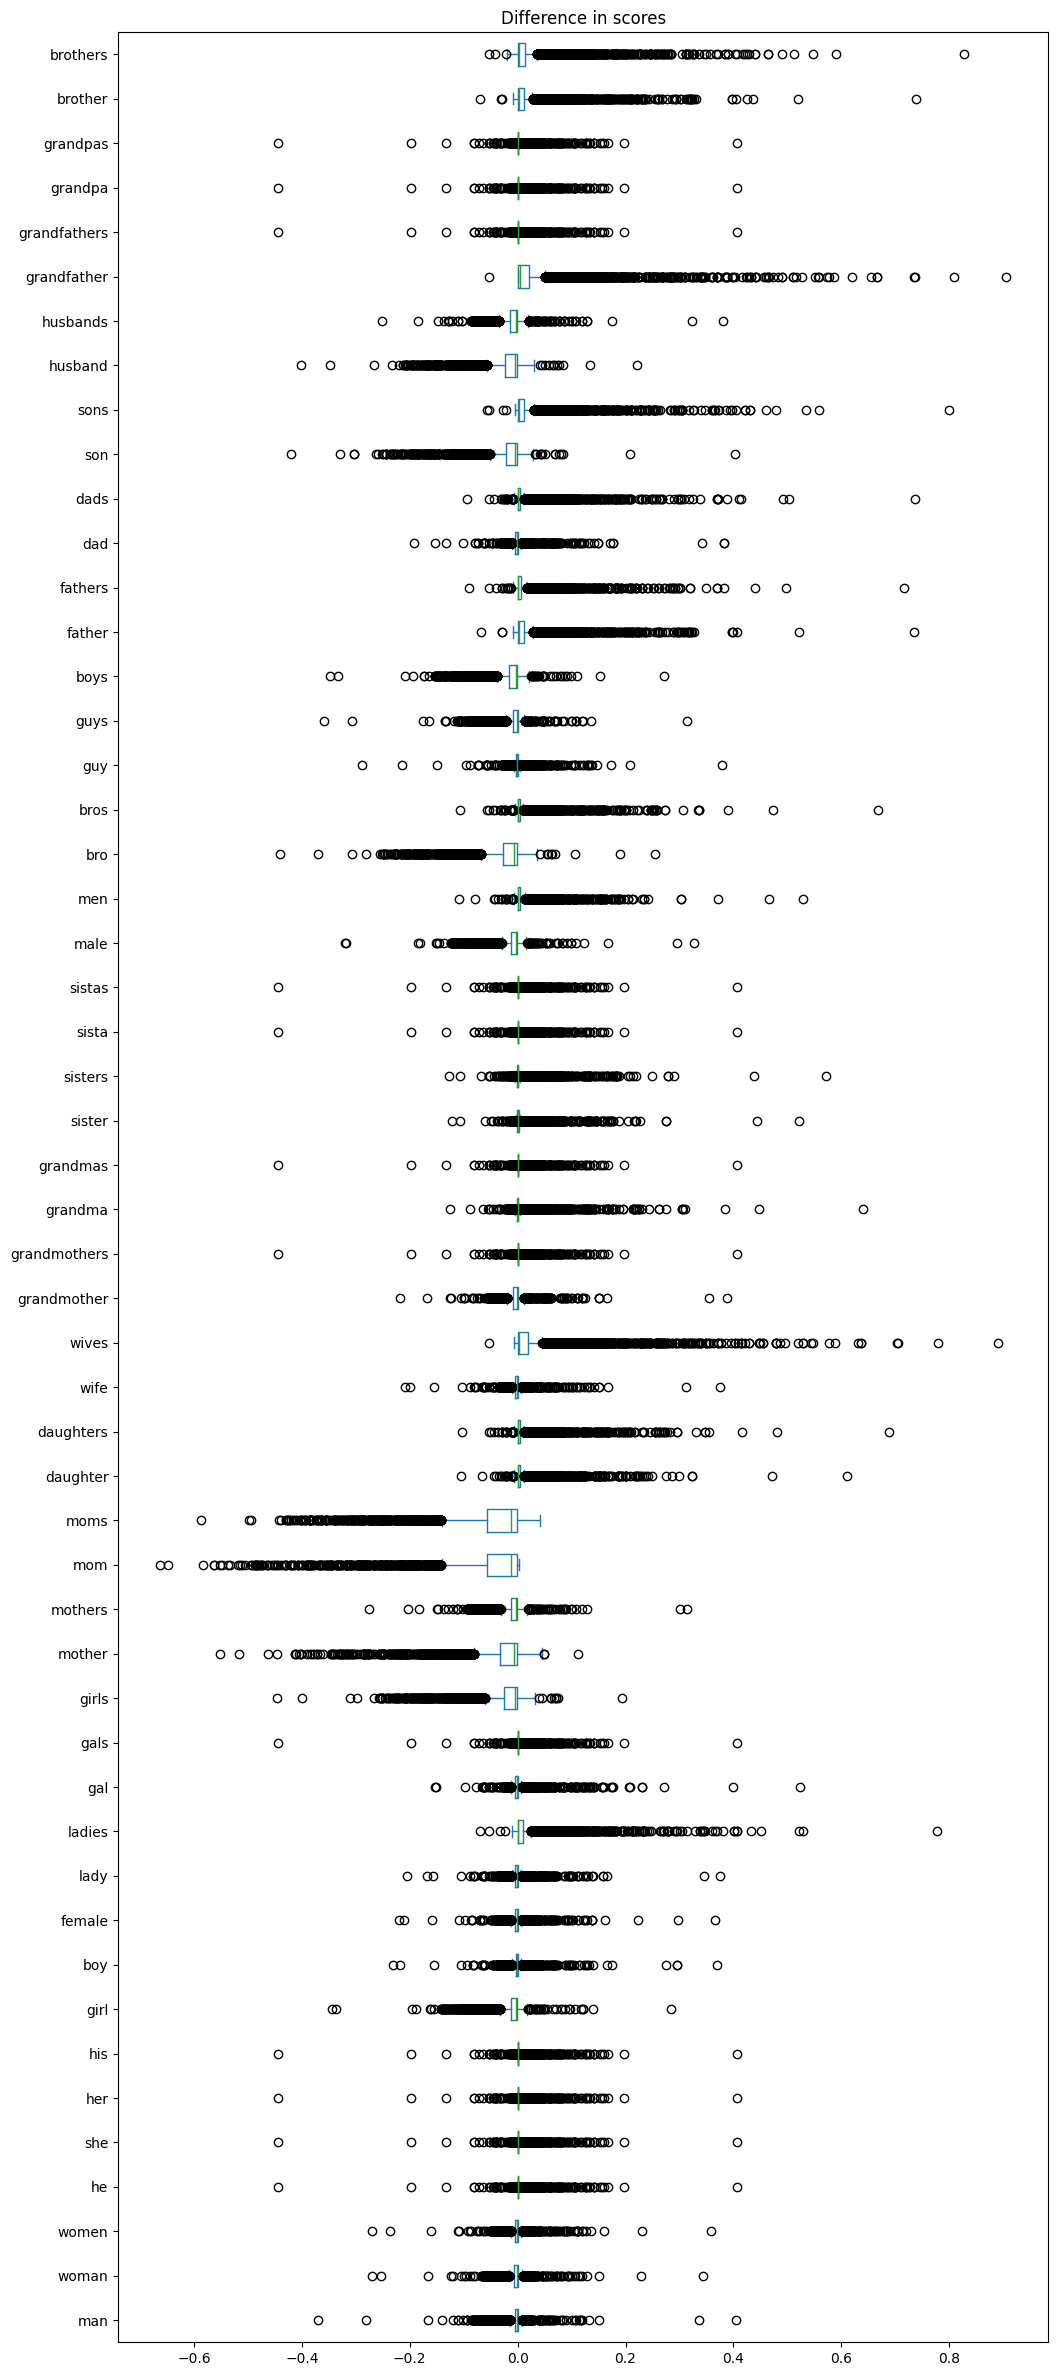

In [189]:
score_df.plot.box(vert=False, figsize=(12, 30));
plt.title("Difference in scores");

SenseScore: 0.018935 (+- 0.046746)


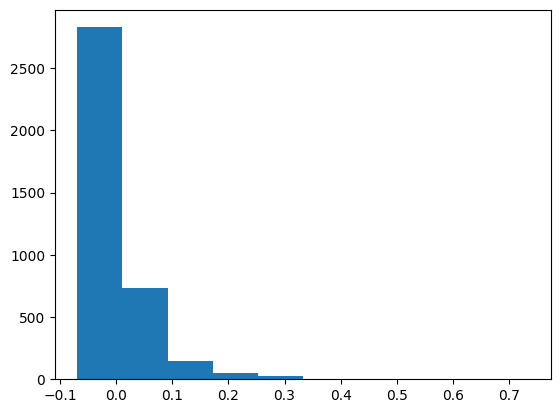

In [197]:
bias_keyword = "father"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

SenseScore: -0.051538 (+- 0.088463)


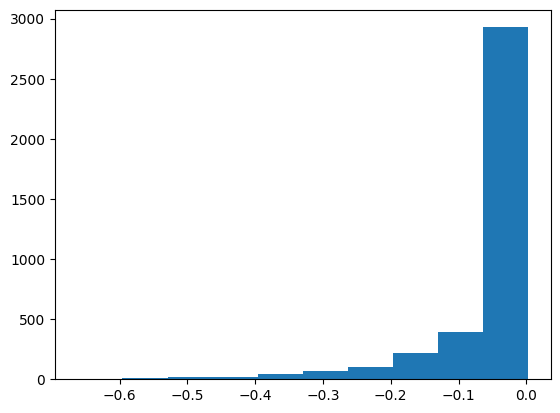

In [196]:
bias_keyword = "mom"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [187]:
religion_score_df = calculate_all_scores(texts=detected_texts, concept="religion", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
10000it [01:25, 116.53it/s]


Extracted 3835 sample texts for concept gender


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.80s/it]


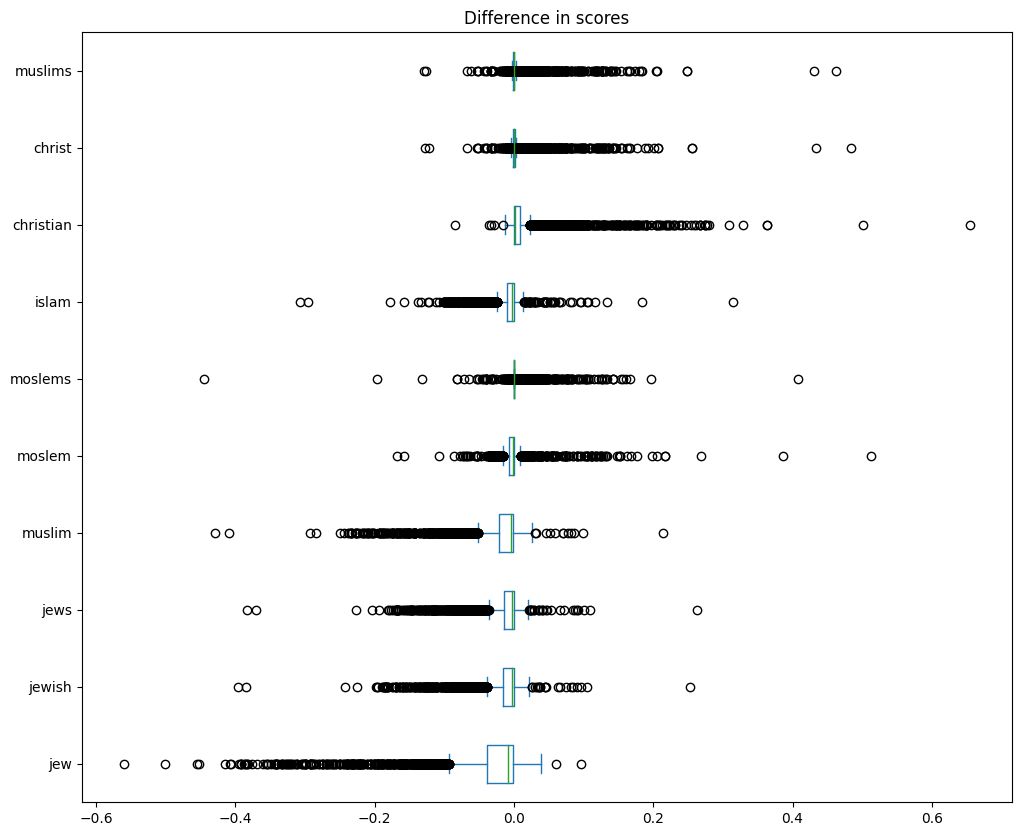

In [211]:
religion_score_df.plot.box(vert=False, figsize=(12, 10));
plt.title("Difference in scores");